In [91]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv("Assignment_data.csv")

# Convert Unix Epoch Time to standard datetime
data['time'] = pd.to_datetime(data['time'], unit='s')

# Sort data by device and time
data = data.sort_values(by=['device', 'time'])

# Create a session identifier by grouping consecutive gameplays
data['session_id'] = (data['device'] != data['device'].shift()) | (data['time'].diff() > pd.Timedelta(hours=1))
data['session_id'] = data['session_id'].cumsum()

# Calculate Average Score per Session
session_scores = data.groupby(['device', 'session_id'])['score'].sum().reset_index()
avg_score_per_session = session_scores.groupby('device')['score'].mean().rename('avg_score_per_session')

# Calculate Total Sessions per Player
total_sessions = session_scores.groupby('device').size().rename('total_sessions')

# Calculate Session Frequency (average time between sessions)
session_times = data.groupby(['device', 'session_id'])['time'].max().reset_index()
session_times['time_diff'] = session_times.groupby('device')['time'].diff().dt.total_seconds()
session_frequency = session_times.groupby('device')['time_diff'].mean().rename('session_frequency')

# Calculate Max Score in a Session
max_score_per_session = session_scores.groupby('device')['score'].max().rename('max_score_per_session')

# Calculate Recency of Last Session
last_session_time = session_times.groupby('device')['time'].max()
data_end_time = data['time'].max()
recency_of_last_session = (data_end_time - last_session_time).dt.days.rename('recency_of_last_session')

# Combine all new features into a single dataframe
new_features = pd.concat([
    avg_score_per_session,
    total_sessions,
    session_frequency,
    max_score_per_session,
    recency_of_last_session
], axis=1).reset_index()

# Merge new features back into the original data
data = data.merge(new_features, on='device', how='left')

# Drop intermediate columns that are no longer needed
data = data.drop(columns=['session_id'], errors='ignore')

# Create the churn feature
churn_period = pd.Timedelta(days=14)
data['last_activity'] = data.groupby('device')['time'].transform('max')
data['churn'] = (data['last_activity'] + churn_period < data['time'].max()).astype(int)


In [92]:
data

,device,score,time,avg_score_per_session,total_sessions,session_frequency,max_score_per_session,recency_of_last_session,last_activity,churn
0,0,45,2015-04-11 11:52:38,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1
1,0,115,2015-04-11 11:53:33,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1
2,0,14,2015-04-11 11:54:32,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1
3,0,237,2016-02-11 07:56:21,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1
4,000000000000000,1,2015-01-23 02:04:44,1518.0,8.0,4.558758e+06,5847.0,118.0,2016-01-27 10:20:57,1
...,...,...,...,...,...,...,...,...,...,...
153924,NaN,847,2015-01-21 14:14:14,NaN,NaN,NaN,NaN,NaN,NaT,0
153925,NaN,374,2015-01-21 14:15:37,NaN,NaN,NaN,NaN,NaN,NaT,0
153926,NaN,35,2015-01-21 14:16:05,NaN,NaN,NaN,NaN,NaN,NaT,0
153927,NaN,112,2015-01-21 14:16:52,NaN,NaN,NaN,NaN,NaN,NaT,0


In [93]:
# Calculate additional features
# 1. Total Score per Player
data['total_score'] = data.groupby('device')['score'].transform('sum')

# 2. Average Score per Session
data['avg_score'] = data.groupby('device')['score'].transform('mean')

# 3. Max Score in a Single Session
data['max_score'] = data.groupby('device')['score'].transform('max')

# 4. Standard Deviation of Scores
data['std_score'] = data.groupby('device')['score'].transform('std').fillna(0)  # Replace NaN with 0 for single-session players

# 5. Days Since First Activity
data['days_since_first'] = (data['time'] - data.groupby('device')['time'].transform('min')).dt.days

# 6. Days Between Sessions
data['days_between_sessions'] = data.groupby('device')['time'].diff().dt.days.fillna(0)  # Fill NaN for first session

# 7. Session Count
data['session_count'] = data.groupby('device')['time'].transform('count')

# 8. Score Density (Score per Day)
data['score_density'] = data['total_score'] / (data['days_since_first'] + 1)  # Avoid division by zero

# 9. Last Session Score Ratio
data['last_session_score'] = data.groupby('device')['score'].transform('last')
data['last_score_ratio'] = data['last_session_score'] / (data['avg_score'] + 1)  # Avoid division by zero

# 10. Activity Intensity (Sessions per Day)
data['activity_intensity'] = data['session_count'] / (data['days_since_first'] + 1)  # Avoid division by zero

data['combined_score'] = data['total_score'] / data['session_count']


In [94]:
data

,device,score,time,avg_score_per_session,total_sessions,session_frequency,max_score_per_session,recency_of_last_session,last_activity,churn,...,max_score,std_score,days_since_first,days_between_sessions,session_count,score_density,last_session_score,last_score_ratio,activity_intensity,combined_score
0,0,45,2015-04-11 11:52:38,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1,...,237.0,98.969271,0.0,0.0,4.0,411.000000,237.0,2.284337,4.000000,102.75
1,0,115,2015-04-11 11:53:33,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1,...,237.0,98.969271,0.0,0.0,4.0,411.000000,237.0,2.284337,4.000000,102.75
2,0,14,2015-04-11 11:54:32,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1,...,237.0,98.969271,0.0,0.0,4.0,411.000000,237.0,2.284337,4.000000,102.75
3,0,237,2016-02-11 07:56:21,205.5,2.0,2.642411e+07,237.0,103.0,2016-02-11 07:56:21,1,...,237.0,98.969271,305.0,305.0,4.0,1.343137,237.0,2.284337,0.013072,102.75
4,000000000000000,1,2015-01-23 02:04:44,1518.0,8.0,4.558758e+06,5847.0,118.0,2016-01-27 10:20:57,1,...,2317.0,398.282132,0.0,0.0,40.0,12144.000000,115.0,0.377544,40.000000,303.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153924,NaN,847,2015-01-21 14:14:14,NaN,NaN,NaN,NaN,NaN,NaT,0,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
153925,NaN,374,2015-01-21 14:15:37,NaN,NaN,NaN,NaN,NaN,NaT,0,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
153926,NaN,35,2015-01-21 14:16:05,NaN,NaN,NaN,NaN,NaN,NaT,0,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
153927,NaN,112,2015-01-21 14:16:52,NaN,NaN,NaN,NaN,NaN,NaT,0,...,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Handling missing data

In [95]:

# Define columns to check for missing values
columns_to_impute = [
    'avg_score_per_session', 'total_sessions', 'session_frequency',
    'max_score_per_session', 'recency_of_last_session',
    'total_score', 'avg_score', 'max_score', 'std_score',
    'days_since_first', 'days_between_sessions', 'session_count',
    'score_density', 'last_score_ratio', 'activity_intensity', 'last_session_score',
    'combined_score'
]

# Filter out non-numeric columns
columns_to_impute = [col for col in columns_to_impute if pd.api.types.is_numeric_dtype(data[col])]

# Check missing values before imputation
print("Missing values before imputation:")
print(data[columns_to_impute].isnull().sum())

# Handle missing values
imputer = SimpleImputer(strategy='mean')
data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

# Check missing values after imputation
print("\nMissing values after imputation:")
print(data[columns_to_impute].isnull().sum())


Missing values before imputation:
avg_score_per_session          9
total_sessions                 9
session_frequency          39425
max_score_per_session          9
recency_of_last_session        9
total_score                    9
avg_score                      9
max_score                      9
std_score                      0
days_since_first               9
days_between_sessions          0
session_count                  9
score_density                  9
last_score_ratio               9
activity_intensity             9
last_session_score             9
combined_score                 9
dtype: int64

Missing values after imputation:
avg_score_per_session      0
total_sessions             0
session_frequency          0
max_score_per_session      0
recency_of_last_session    0
total_score                0
avg_score                  0
max_score                  0
std_score                  0
days_since_first           0
days_between_sessions      0
session_count              0
score_dens

In [96]:
data

,device,score,time,avg_score_per_session,total_sessions,session_frequency,max_score_per_session,recency_of_last_session,last_activity,churn,...,max_score,std_score,days_since_first,days_between_sessions,session_count,score_density,last_session_score,last_score_ratio,activity_intensity,combined_score
0,0,45,2015-04-11 11:52:38,205.500000,2.000000,2.642411e+07,237.000000,103.000000,2016-02-11 07:56:21,1,...,237.000000,98.969271,0.000000,0.0,4.000000,411.000000,237.000000,2.284337,4.000000,102.750000
1,0,115,2015-04-11 11:53:33,205.500000,2.000000,2.642411e+07,237.000000,103.000000,2016-02-11 07:56:21,1,...,237.000000,98.969271,0.000000,0.0,4.000000,411.000000,237.000000,2.284337,4.000000,102.750000
2,0,14,2015-04-11 11:54:32,205.500000,2.000000,2.642411e+07,237.000000,103.000000,2016-02-11 07:56:21,1,...,237.000000,98.969271,0.000000,0.0,4.000000,411.000000,237.000000,2.284337,4.000000,102.750000
3,0,237,2016-02-11 07:56:21,205.500000,2.000000,2.642411e+07,237.000000,103.000000,2016-02-11 07:56:21,1,...,237.000000,98.969271,305.000000,305.0,4.000000,1.343137,237.000000,2.284337,0.013072,102.750000
4,000000000000000,1,2015-01-23 02:04:44,1518.000000,8.000000,4.558758e+06,5847.000000,118.000000,2016-01-27 10:20:57,1,...,2317.000000,398.282132,0.000000,0.0,40.000000,12144.000000,115.000000,0.377544,40.000000,303.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153924,NaN,847,2015-01-21 14:14:14,928.088027,19.677228,7.685628e+05,2988.706919,265.785843,NaT,0,...,889.185616,0.000000,20.112916,0.0,126.465683,5143.795710,227.713325,1.136714,29.875625,195.927034
153925,NaN,374,2015-01-21 14:15:37,928.088027,19.677228,7.685628e+05,2988.706919,265.785843,NaT,0,...,889.185616,0.000000,20.112916,0.0,126.465683,5143.795710,227.713325,1.136714,29.875625,195.927034
153926,NaN,35,2015-01-21 14:16:05,928.088027,19.677228,7.685628e+05,2988.706919,265.785843,NaT,0,...,889.185616,0.000000,20.112916,0.0,126.465683,5143.795710,227.713325,1.136714,29.875625,195.927034
153927,NaN,112,2015-01-21 14:16:52,928.088027,19.677228,7.685628e+05,2988.706919,265.785843,NaT,0,...,889.185616,0.000000,20.112916,0.0,126.465683,5143.795710,227.713325,1.136714,29.875625,195.927034


### Train/test split

In [102]:

# Prepare features and target variable
# features = ['avg_score_per_session', 'total_sessions', 'session_frequency', 
#             'max_score_per_session', 'recency_of_last_session']
# features = data.drop(columns=['churn', 'recency_of_last_session', 'device', 'last_activity',
#                               'time'])
features = [
    'score',
    'session_frequency',
    'days_since_first',
    'days_between_sessions',
    'activity_intensity',
    'total_sessions',
    'score_density',
    'std_score'
]

X = data[features]

y = data['churn']


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


## SMOTE

In [103]:

# Print percentage of churners in the training set before SMOTE
churners_before = y_train.sum() / len(y_train) * 100
print(f"Percentage of churners before SMOTE: {churners_before:.2f}%")

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print percentage of churners in the training set after SMOTE
churners_after = y_train_resampled.sum() / len(y_train_resampled) * 100
print(f"Percentage of churners after SMOTE: {churners_after:.2f}%")


Percentage of churners before SMOTE: 97.26%
Percentage of churners after SMOTE: 50.00%


### Checking for multicolinearity

In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant column to the feature set for VIF calculation
X_train_const = add_constant(X_train_resampled)

# Calculate VIF for each feature, including the constant
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_const.columns  # Use columns from X_train_const to match the VIF calculation
vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]

print(vif_data)


                 Feature       VIF
0                  const  2.279549
1                  score  1.389576
2      session_frequency  1.175047
3       days_since_first  1.292667
4  days_between_sessions  1.161193
5     activity_intensity  2.406849
6         total_sessions  1.232173
7          score_density  2.418516
8              std_score  1.467700


In [105]:
# droppping features with high VIF score
# X_train_reduced = X_train.drop(columns=['max_score', 'max_score_per_session', 'total_score', 'session_count'])


## Logistic Regression

In [107]:
# # Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [109]:

# Train a logistic regression model with 5-fold cross-validation
model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42)

# Perform Stratified 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=skf, scoring='accuracy')

# Print Cross-Validation Results
print("\nCross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

# Train the model on the full resampled training data
model.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model on the test set
print("\nAccuracy Score on Test Set:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix on Test Set:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred))



Cross-Validation Accuracy Scores: [0.61214753 0.61166114 0.61387981 0.61218599 0.61120786]
Mean Cross-Validation Accuracy: 0.6122164651691385

Accuracy Score on Test Set: 0.8059074471079928

Confusion Matrix on Test Set:
 [[  514   754]
 [ 8209 36702]]

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.06      0.41      0.10      1268
           1       0.98      0.82      0.89     44911

    accuracy                           0.81     46179
   macro avg       0.52      0.61      0.50     46179
weighted avg       0.95      0.81      0.87     46179



## Random Forest

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Random Forest: Define parameter grid
# rf_params = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4]
# }

# Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
rf_params = {'max_depth': [None], 'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [100]}

# Random Forest: Initialize model and grid search
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)

# Fit Random Forest with grid search
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and accuracy for Random Forest
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_
print("Random Forest Best Parameters:", rf_best_params)
print("Random Forest Best CV Accuracy:", rf_best_score)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best CV Accuracy: 0.989507898950662


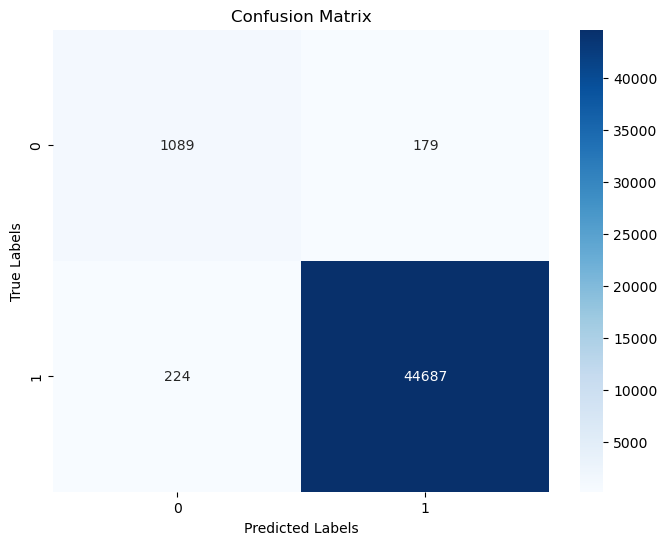

Confusion Matrix:
[[ 1089   179]
 [  224 44687]]


In [114]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the best estimator from grid search
best_rf_model = rf_grid_search.best_estimator_

# Step 2: Make predictions using the test data (or validation set)
y_pred = best_rf_model.predict(X_test)  # Assuming X_test and y_test are your test set

# Step 3: Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 4: Plot the confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print the confusion matrix
print("Confusion Matrix:")
print(cm)


## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# XGBoost: Define parameter grid
xgb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [2, 3, 4, 6],
    # "subsample": [0.8, 1.0],
    # "colsample_bytree": [0.8, 1.0]
}

# XGBoost: Initialize model and grid search
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)

# Fit XGBoost with grid search
xgb_grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and accuracy for XGBoost
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = xgb_grid_search.best_score_
print("XGBoost Best Parameters:", xgb_best_params)
print("XGBoost Best CV Accuracy:", xgb_best_score)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src

KeyboardInterrupt: 